In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import joblib
import keras
import matplotlib.pyplot as plt

In [2]:
TEST_DAYS = 50
PERIOD = '5y'

In [3]:
INDICATOR_DATASET = False

In [18]:
INCLUDE_COMMODITIES = True

In [5]:
if INDICATOR_DATASET:
    d = joblib.load('nifty_data.pkl')
else:
    d = yf.download(
                tickers="^NSEI",
                period=PERIOD,
                interval='1d',
                progress=False,
                timeout=10
            )
    if INCLUDE_COMMODITIES:
        gold = yf.download(
                    tickers="GC=F",
                    period=PERIOD,
                    interval='1d',
                    progress=False,
                    timeout=10
                ).add_prefix(prefix='gold_')
        crude = yf.download(
                    tickers="CL=F",
                    period=PERIOD,
                    interval='1d',
                    progress=False,
                    timeout=10
                ).add_prefix(prefix='crude_')
        d = pd.concat([d, gold, crude], axis=1)
    
    d['target'] = d.Open/d.Close.shift(-1)
    d.target = d.target.apply(np.floor)

    d['change'] = abs(d['Close'].pct_change() * 100)

    d['High'] = d['High'].pct_change() * 100
    d['Low'] = d['Low'].pct_change() * 100
    d['Open'] = d['Open'].pct_change() * 100
    d['Close'] = d['Close'].pct_change() * 100 

    if INCLUDE_COMMODITIES:
        d['gold_High'] = d['gold_High'].pct_change() * 100
        d['gold_Low'] = d['gold_Low'].pct_change() * 100
        d['gold_Open'] = d['gold_Open'].pct_change() * 100
        d['gold_Close'] = d['gold_Close'].pct_change() * 100

        d['crude_High'] = d['crude_High'].pct_change() * 100
        d['crude_Low'] = d['crude_Low'].pct_change() * 100
        d['crude_Open'] = d['crude_Open'].pct_change() * 100
        d['crude_Close'] = d['crude_Close'].pct_change() * 100
    # d.rename(columns = {'HighNew':'High','LowNew':'Low','OpenNew':'Open','CloseNew':'Close'}, inplace = True)

    # Remove outliers when Market closes +- 3.5%
    d = d[d['change'] < 3]
    d.dropna(inplace=True)
    d.tail()

In [6]:
def preprocessBeforeScaling(df):
    df['High'] = df['High'].pct_change() * 100
    df['Low'] = df['Low'].pct_change() * 100
    df['Open'] = df['Open'].pct_change() * 100
    df['Close'] = df['Close'].pct_change() * 100 

    if INCLUDE_COMMODITIES:
        df['gold_High'] = df['gold_High'].pct_change() * 100
        df['gold_Low'] = df['gold_Low'].pct_change() * 100
        df['gold_Open'] = df['gold_Open'].pct_change() * 100
        df['gold_Close'] = df['gold_Close'].pct_change() * 100

        df['crude_High'] = df['crude_High'].pct_change() * 100
        df['crude_Low'] = df['crude_Low'].pct_change() * 100
        df['crude_Open'] = df['crude_Open'].pct_change() * 100
        df['crude_Close'] = df['crude_Close'].pct_change() * 100
    return df

In [7]:
test_dataset = d.tail(TEST_DAYS)

In [8]:
d = d[:-(TEST_DAYS+1)]

In [9]:
if INDICATOR_DATASET:
    x = d.drop(columns=['target'])
    y = d.target
else:
    if INCLUDE_COMMODITIES:
        # x = d.drop(columns=['target', 'Adj Close', 'Volume', 'change', 'gold_Adj Close', 'gold_Volume', 'crude_Adj Close', 'crude_Volume'], errors='ignore')
        x = d.drop(columns=['target', 'Adj Close', 'Volume', 'change', 'gold_Open', 'gold_High', 'gold_Low', 'gold_Adj Close', 'gold_Volume', 'crude_Open', 'crude_High', 'crude_Low', 'crude_Adj Close', 'crude_Volume'], errors='ignore')
    else:
        x = d.drop(columns=['target', 'Adj Close', 'Volume', 'change'], errors='ignore')
    y = d.target

In [10]:
x

,Open,High,Low,Close,gold_Close,crude_Close
Date,,,,,,
2018-10-23,-2.433727,-1.791318,-1.189851,-0.960935,0.999023,-3.961252
2018-10-24,1.236637,0.670614,0.241039,0.768224,-0.454028,0.587083
2018-10-25,-1.392280,-1.205471,-0.468073,-0.976548,0.105874,0.763248
2018-10-26,-0.125310,-0.371314,-0.741619,-0.937297,0.276627,0.386150
2018-10-29,-0.437151,1.445872,0.157926,2.201890,-0.649087,-0.813723
...,...,...,...,...,...,...
2023-07-25,-0.096714,-0.269934,-0.215439,0.041937,0.091819,1.130302
2023-07-26,0.020274,0.487852,0.513613,0.496434,0.346570,-1.067435
2023-07-27,0.595696,0.211601,-0.573871,-0.598638,-1.193560,1.662856


In [11]:
y

Date
2018-10-23    0.0
2018-10-24    1.0
2018-10-25    1.0
2018-10-26    0.0
2018-10-29    0.0
             ... 
2023-07-25    0.0
2023-07-26    1.0
2023-07-27    1.0
2023-07-28    0.0
2023-07-31    0.0
Name: target, Length: 1059, dtype: float64

In [12]:
print('No. of Bullish samples: {}'.format(y[y == 0].size))
print('No. of Bearish samples: {}'.format(y[y == 1].size))

No. of Bullish samples: 554
No. of Bearish samples: 505


In [13]:
if not INDICATOR_DATASET:
    print("Using StandardScaler")
    scaler = StandardScaler()
    x = scaler.fit_transform(x.to_numpy())
    x
else:
    print("Using ColumnTransformer")
    col_names = ['Open', 'High', 'Low', 'Close', 'ATR']
    scaler = ColumnTransformer(
        [('StandardScaler', StandardScaler(), col_names)],
        remainder='passthrough'
    )
    x = scaler.fit_transform(x)
x

Using StandardScaler


array([[-2.20749184, -2.15630367, -1.28386843, -1.12858003,  1.00255906,
        -0.38714857],
       [ 1.02520233,  0.70696761,  0.15712183,  0.76864741, -0.54208534,
         0.07144068],
       [-1.29023079, -1.4749529 , -0.5569958 , -1.14571072,  0.05311023,
         0.0892026 ],
       ...,
       [ 0.4606901 ,  0.17312764, -0.66354028, -0.73106887, -1.32823429,
         0.17990622],
       [-0.91207923, -1.07778541, -0.2934211 , -0.1515387 ,  0.76021492,
         0.07393465],
       [-0.03440639,  0.38081913,  0.09197882,  0.5275186 ,  0.48823743,
         0.16490025]])

In [21]:
import tensorflow as tf
from keras import Sequential
from keras import Model
from keras.layers import Dense
from keras.optimizers import legacy
import keras

lr_list = []
def scheduler(epoch, lr):
    if epoch < 10:
        lr = lr
    else:
        lr = lr * tf.math.exp(-0.01)
    lr_list.append(lr)
    return lr

units = 128 #1024
# sgd = SGD(learning_rate=0.0001, momentum=0.0, nesterov=True)
sgd = legacy.SGD(learning_rate=0.001, momentum=0.45, nesterov=True)
kernel_init = 'he_uniform'
activation = 'relu'

callback_mc = keras.callbacks.ModelCheckpoint(
                'best_model.h5',
                verbose=1,
                monitor='val_accuracy',
                save_best_only=True,
                mode='auto'
                )
callback_es = keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='auto',
                verbose=0,
                patience=200
)
callback_lr = keras.callbacks.LearningRateScheduler(scheduler)

model = Sequential([
    Dense(units, kernel_initializer=kernel_init, activation=activation, input_dim=x.shape[1]),
    # Dense(units, kernel_initializer=kernel_init, activation=activation),
    Dense(units//2, kernel_initializer=kernel_init, activation=activation),
    Dense(units//4, kernel_initializer=kernel_init, activation=activation),
    Dense(units//8, kernel_initializer=kernel_init, activation=activation),
    Dense(units//16, kernel_initializer=kernel_init, activation=activation),
    Dense(units//32, kernel_initializer=kernel_init, activation=activation),
    Dense(1, kernel_initializer=kernel_init, activation='sigmoid'),
])
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               896       
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 4)                 36        
                                                                 
 dense_13 (Dense)            (None, 1)                

In [22]:
BATCH_SIZE = int(len(y)/6.6125) #128 #24 #4
print(f'BATCH SIZE = {BATCH_SIZE}')
history = model.fit(x, y, callbacks=[callback_mc, callback_es, callback_lr], batch_size=BATCH_SIZE, epochs=750, validation_split=0.15, verbose=2)

BATCH SIZE = 160
Epoch 1/750

Epoch 1: val_accuracy improved from -inf to 0.40881, saving model to best_model.h5
6/6 - 5s - loss: 2.2815 - accuracy: 0.3682 - val_loss: 1.2598 - val_accuracy: 0.4088 - lr: 0.0010 - 5s/epoch - 765ms/step
Epoch 2/750

Epoch 2: val_accuracy improved from 0.40881 to 0.44654, saving model to best_model.h5
6/6 - 0s - loss: 1.7582 - accuracy: 0.4060 - val_loss: 1.1155 - val_accuracy: 0.4465 - lr: 0.0010 - 88ms/epoch - 15ms/step
Epoch 3/750

Epoch 3: val_accuracy improved from 0.44654 to 0.47170, saving model to best_model.h5
6/6 - 0s - loss: 1.4263 - accuracy: 0.4449 - val_loss: 0.9977 - val_accuracy: 0.4717 - lr: 0.0010 - 85ms/epoch - 14ms/step
Epoch 4/750


/Users/pranjaljoshi/miniforge3/envs/screenipy/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_accuracy did not improve from 0.47170
6/6 - 0s - loss: 1.2121 - accuracy: 0.4883 - val_loss: 0.8805 - val_accuracy: 0.4654 - lr: 0.0010 - 66ms/epoch - 11ms/step
Epoch 5/750

Epoch 5: val_accuracy improved from 0.47170 to 0.52830, saving model to best_model.h5
6/6 - 0s - loss: 1.0301 - accuracy: 0.5106 - val_loss: 0.7915 - val_accuracy: 0.5283 - lr: 0.0010 - 82ms/epoch - 14ms/step
Epoch 6/750

Epoch 6: val_accuracy improved from 0.52830 to 0.59119, saving model to best_model.h5
6/6 - 0s - loss: 0.9162 - accuracy: 0.5328 - val_loss: 0.7282 - val_accuracy: 0.5912 - lr: 0.0010 - 80ms/epoch - 13ms/step
Epoch 7/750

Epoch 7: val_accuracy improved from 0.59119 to 0.63522, saving model to best_model.h5
6/6 - 0s - loss: 0.8414 - accuracy: 0.5940 - val_loss: 0.6987 - val_accuracy: 0.6352 - lr: 0.0010 - 81ms/epoch - 14ms/step
Epoch 8/750

Epoch 8: val_accuracy improved from 0.63522 to 0.64780, saving model to best_model.h5
6/6 - 0s - loss: 0.8066 - accuracy: 0.6151 - val_loss: 0.683

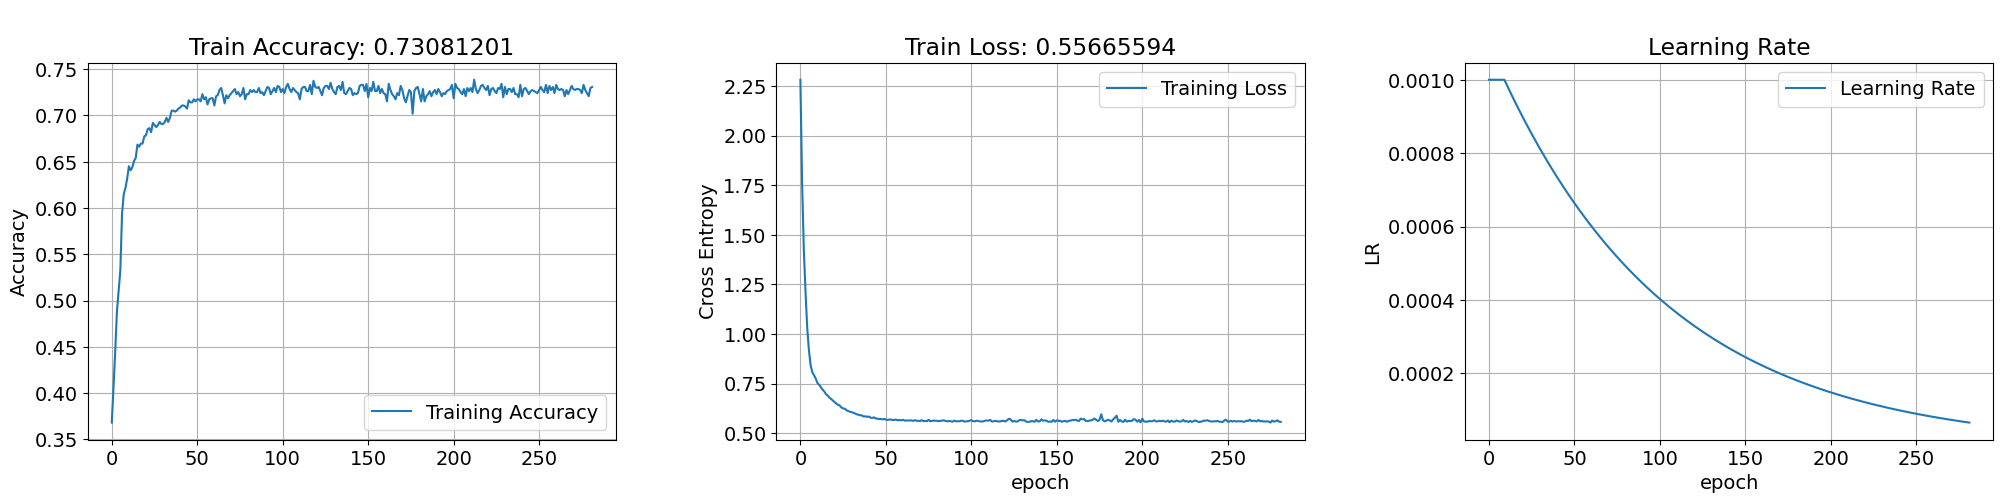

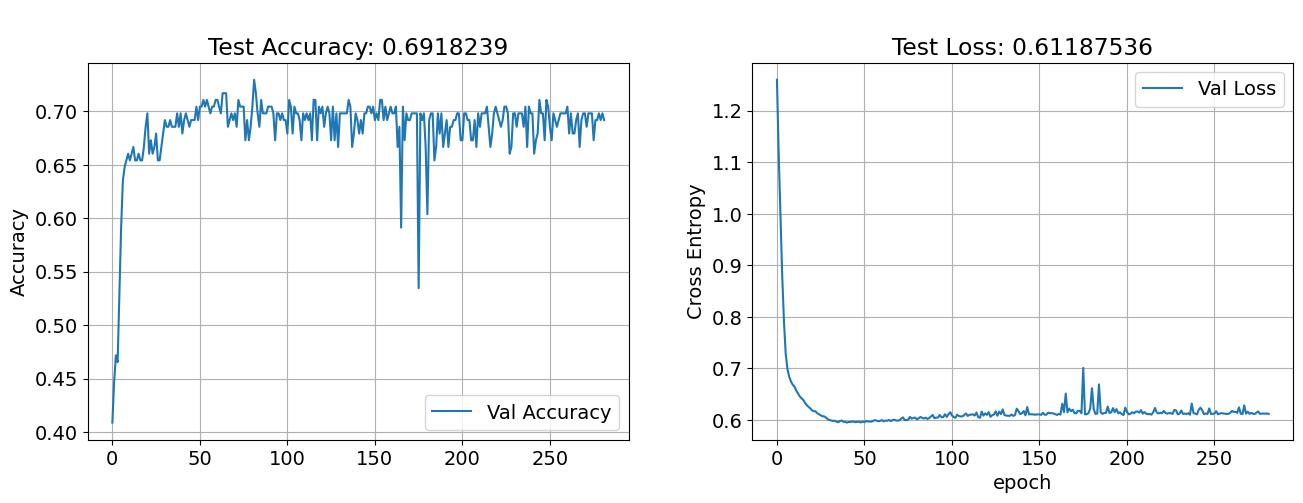

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(21,6))
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'

plt.subplot(1, 3, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTrain Accuracy: {round(acc[-1],8)}')

plt.subplot(1, 3, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'\nTrain Loss: {round(loss[-1],8)}')
plt.xlabel('epoch')

plt.subplot(1, 3, 3)
plt.plot(lr_list, label='Learning Rate')
plt.legend(loc='upper right')
plt.ylabel('LR')
plt.title(f'\nLearning Rate')
plt.xlabel('epoch')

plt.tight_layout(pad=3.0)
plt.show()

acc = history.history['val_accuracy']
loss = history.history['val_loss']

plt.figure(figsize=(14,6))
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(1, 2, 1)
plt.plot(acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTest Accuracy: {round(acc[-1],8)}')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Val Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'\nTest Loss: {round(loss[-1],8)}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

## Try Realtime Inference

In [14]:
metrics = {
    "TP": 0, "FP": 0, "TN": 0, "FN": 0
}

In [15]:
endpoint = keras.models.load_model('nifty_model_v3.h5')
try:
    scaler
except NameError:
    pkl = joblib.load('nifty_model.pkl')
    scaler = pkl['scaler']
today = yf.download(
                tickers="^NSEI",
                period=f'{TEST_DAYS}d',
                interval='1d',
                progress=False,
                timeout=10
            )
if INCLUDE_COMMODITIES:
    gold = yf.download(
                    tickers="GC=F",
                    period=f'{TEST_DAYS}d',
                    interval='1d',
                    progress=False,
                    timeout=10
                ).add_prefix(prefix='gold_')
    crude = yf.download(
                tickers="CL=F",
                period=f'{TEST_DAYS}d',
                interval='1d',
                progress=False,
                timeout=10
            ).add_prefix(prefix='crude_')

    today = pd.concat([today, gold, crude], axis=1)
    today = today.drop(columns=['Adj Close', 'Volume', 'gold_Adj Close', 'gold_Volume', 'crude_Adj Close', 'crude_Volume'])
else:
    today = today.drop(columns=['Adj Close', 'Volume'])

###
today = preprocessBeforeScaling(today)
today = today.drop(columns=['gold_Open', 'gold_High', 'gold_Low', 'crude_Open', 'crude_High', 'crude_Low'])
###

cnt_correct, cnt_wrong = 0, 0
for i in range(-TEST_DAYS,0):
    df = today.iloc[i]
    twr = today.iloc[i+1]['Close']
    df = scaler.transform([df])
    pred = endpoint.predict([df], verbose=0)

    if twr > today.iloc[i]['Open']:
        fact = "BULLISH"
    else:
        fact = "BEARISH"

    if pred > 0.5:
        out = "BEARISH"
    else:
        out = "BULLISH"

    if out == fact:
        cnt_correct += 1
        if out == "BULLISH":
            metrics["TP"] += 1
        else:
            metrics["TN"] += 1
    else:
        cnt_wrong += 1
        if out == "BULLISH":
            metrics["FN"] += 1
        else:
            metrics["FP"] += 1

        
    print("{} Nifty Prediction -> Market may Close {} on {}! Actual -> {}, Prediction -> {}, Pred = {}".format(
            today.iloc[i].name.strftime("%d-%m-%Y"),
            out,
            (today.iloc[i].name + pd.Timedelta(days=1)).strftime("%d-%m-%Y"),
            fact,
            "Correct" if fact == out else "Wrong",
            str(np.round(pred[0][0], 2))
            )
        )

print("Correct: {}, Wrong: {}, Accuracy: {}".format(cnt_correct, cnt_wrong, cnt_correct/(cnt_correct+cnt_wrong)))
print(metrics)

2023-10-20 15:46:29.966870: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-20 15:46:29.966900: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-20 15:46:29.966905: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-20 15:46:29.967252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-20 15:46:29.967459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-20 15:46:32.474441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11-08-2023 Nifty Prediction -> Market may Close BULLISH on 12-08-2023! Actual -> BULLISH, Prediction -> Correct, Pred = nan
14-08-2023 Nifty Prediction -> Market may Close BULLISH on 15-08-2023! Actual -> BULLISH, Prediction -> Correct, Pred = nan
16-08-2023 Nifty Prediction -> Market may Close BULLISH on 17-08-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
17-08-2023 Nifty Prediction -> Market may Close BULLISH on 18-08-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
18-08-2023 Nifty Prediction -> Market may Close BULLISH on 19-08-2023! Actual -> BULLISH, Prediction -> Correct, Pred = nan
21-08-2023 Nifty Prediction -> Market may Close BULLISH on 22-08-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
22-08-2023 Nifty Prediction -> Market may Close BULLISH on 23-08-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
23-08-2023 Nifty Prediction -> Market may Close BULLISH on 24-08-2023! Actual -> BEARISH, Prediction -> Wrong, Pred = nan
24-08-2023 Nifty P

## Save Model for Screeni-py integration

In [26]:
pkl = {
    #  'model': model,
    'scaler': scaler,
    'columns': ['Open', 'Close', 'High', 'Low', 'gold_Close', 'crude_Close']
}

joblib.dump(pkl, 'nifty_model.pkl')

['nifty_model.pkl']

In [25]:
pkl = joblib.load('nifty_model.pkl')
z = yf.download(
                tickers="^NSEI",
                period='5d',
                interval='1d',
                progress=False,
                timeout=10
            )
if INCLUDE_COMMODITIES:
    gold = yf.download(
                tickers="GC=F",
                period='5d',
                interval='1d',
                progress=False,
                timeout=10
            ).add_prefix(prefix='gold_')
    crude = yf.download(
                tickers="CL=F",
                period='5d',
                interval='1d',
                progress=False,
                timeout=10
            ).add_prefix(prefix='crude_')
    z = pd.concat([z, gold, crude], axis=1)
z = preprocessBeforeScaling(z)
z = z.iloc[-1]
z = z[pkl['columns']]
print(z)
z = pkl['scaler'].transform([z])
endpoint.predict(z)

Open          -0.015599
Close         -0.418090
High          -0.447114
Low            0.032541
gold_Close     1.325949
crude_Close    1.242028
Name: 2023-10-20 00:00:00, dtype: float64
1/1 [==============================] - 0s 15ms/step


array([[0.52346516]], dtype=float32)

In [ ]:
z = yf.download(
                tickers="^NSEI",
                period='5d',
                interval='1d',
                progress=False,
                timeout=10
            )
z = preprocessBeforeScaling(z)
z

In [ ]:
pkl['model'].save('nifty_model.h5')

In [ ]:
pkl

In [ ]:
del pkl['model']

In [ ]:
pkl

In [ ]:
def getSigmoidConfidence(x):
    out_min, out_max = 0, 100
    if x > 0.5:
        in_min = 0.50001
        in_max = 1
    else:
        in_min = 0
        in_max = 0.5
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

map_range(0.9633487, 0.5, 1, 0, 100)